<a href="https://colab.research.google.com/github/rafael-albuquerque-oliveira/analise-fraudes-cartoes/blob/main/aval_fraude_cartao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de Fraudes em Cartões de Crédito**

Neste estudo vamos abordar as fraudes em cartões de crédito, uma das maiores preocupações de insituições financeiras, como fintechs e bancos.

É importante ressaltar que fraude, por definição, é todo e qualquer ato que leva um usuário ou empresa ao engano, por meio de falsificações, e cujo objetivo é levar vantagem. 

No Brasil, entre as fraudes mais comuns estão as bancárias e as realizadas via internet.

Dentre estas fraudes, as relativas a cartões de crédito são de grande relevância, visto que a sua não-detecção acarretará grandes prejuízos tanto para o consumidor quanto para a insituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que, provavelmente, gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em Data Science.

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## **1. Importação dos Dados**

Os dados que utilizaremos foram disponibilizados por empresas de cartão de crédito europeias, e contêm movimentações feitas em setembro de 2013, durante dois dias, onde foram encontradas 492 fraudes entre 284.807 transações. Como podemos notar, este dataset é altamente desbalanceado, onde as classes positivas (fraudes) representam apenas 0,172% de todas as transações.

Outro ponto interessante de ser notado é que todas as features são numéricas, devido questões de confidencialidade, e portanto, não podemos conseguir maiores contextos para estas informações. Logo, as colunas estão nomeadas por V1, V2, V3, V4..., V28.

Este dataset está disponível nesta [página do Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv), onde tambem é informado que os dados passaram por uma transformação chamada de [Análise de Componentes Principais (Principal Component Analysis - PCA)](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf). 

O PCA permite a redução de dimensionalidade enquanto mantém o maior número possível de informações. Para alcançar isso, o algoritmo encontra um novo conjunto de recursos, os chamados **componentes principais**.

Esse conjunto de componentes possui uma quantidade igual ou menor ao número de variáveis originais. Para este projeto, os componentes achados pelo PCA são as próprias features V1, V2, ..., v28.

In [ ]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -q scikit-plot
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# Para trabalhar o desbalanceamento das classes
from imblearn.under_sampling import RandomUnderSampler

# Para suprimir os warnings de mudanças futuras
from warnings import simplefilter
simplefilter(action='ignore', category='FutureWarning')

# Definir o estilo do Seaborn
sns.set_style('whitegrid')

Os dados estão em uma pasta no Drive, mas podem ser encontrados neste [link](https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importação dos dados em um dataframe
df = pd.read_csv('/content/drive/MyDrive/Portfolio/analise-fraude-cartao/Dados/creditcard.csv')

## **2. Análise Exploratória dos Dados**

Para começarmos a entender o dataset, iremos visualizar as primeiras linhas do dataframe.

In [ ]:
# Visualizar as 5 primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Em uma primeira análise, é possível notar que:

* A transformação PCA deixou as classes descaracterizadas e em valores numéricos;
* As colunas TIme e Amount mantiveram os valores originais;
* A variável alvo está na coluna Class, onde:
    * 0: Transação normal; e
    * 1: Transação fraudulenta.

Para termos uma noção melhor de qual é a situação estatística dos dados, utilizaremos a função 'describe()'.



In [ ]:
# Visualizar o resumo estatístico do dataframe
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente, bem como a coluna Time também não.

Em relação à variável Amount, nota-se que o valor médio de transações (considerando ambas as classes) é 88.35, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado.

In [ ]:
# Para visualizar a quantidade de dados nulos
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Quanto a presença de dados nulos, podemos ver acima que o dataset não possui valores nesta situação.

Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total.

O gráfico de barras mostra como essa discrepância se torna nítida e visível. Na prática, isso interfere no desempenho do modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% dos valores totais.


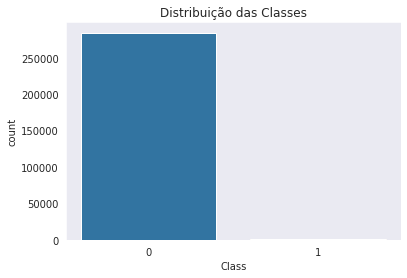

In [ ]:
# Para ver o balanceamento das classes
print(df.Class.value_counts())
print(f'\nFraudes representam {((df[df.Class == 1].shape[0]/df.shape[0])*100):.4f}% dos valores totais.')

# Gráfico de barras para visualizarmos a distribuição de classes
fig, ax = plt.subplots()
sns.countplot(x = df.Class, data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot();

Vamos plotar também dois gráficos a fim de comparar as distribuições das 2 classes ao longo da dimensão tempo.

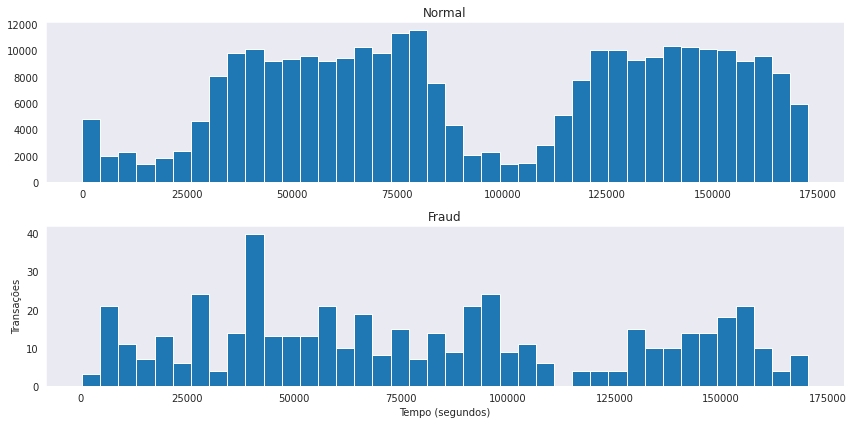

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title('Fraud')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

No entanto, não foi identificada nenhum informação a partir das distribuições de frequência acima.

Seguindo a análise exploratória, também iremos plotar os *boxplots* para ver se há alguma diferença no padrão transações em relação à dimensão `Amount`.


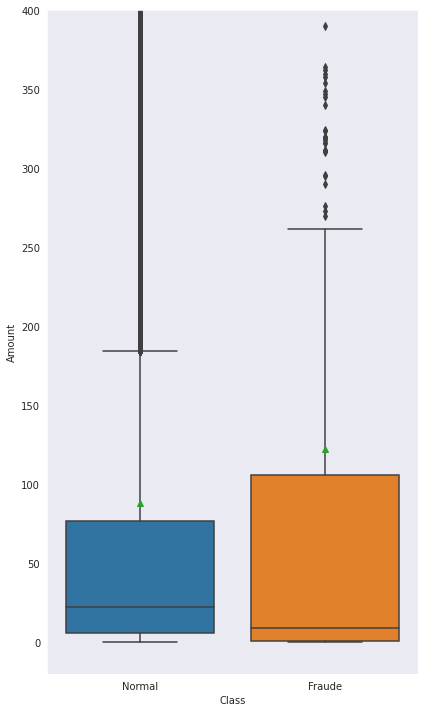

In [ ]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

De uma maneira geral, podemos perceber uma distribuição diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de machine learning.

O gráfico de densidade é uma boa opção para compararmos as distribuições de cada variável para cada classe, e notarmos as mais importantes para a detecção de anomalias.

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis V3, V4, V10 e V11, como elas são bem distintas.

Por outro lado, variáveis como V8, V13 e V15 são muito similares, apresentando aproximadamente o mesmo comportamento.

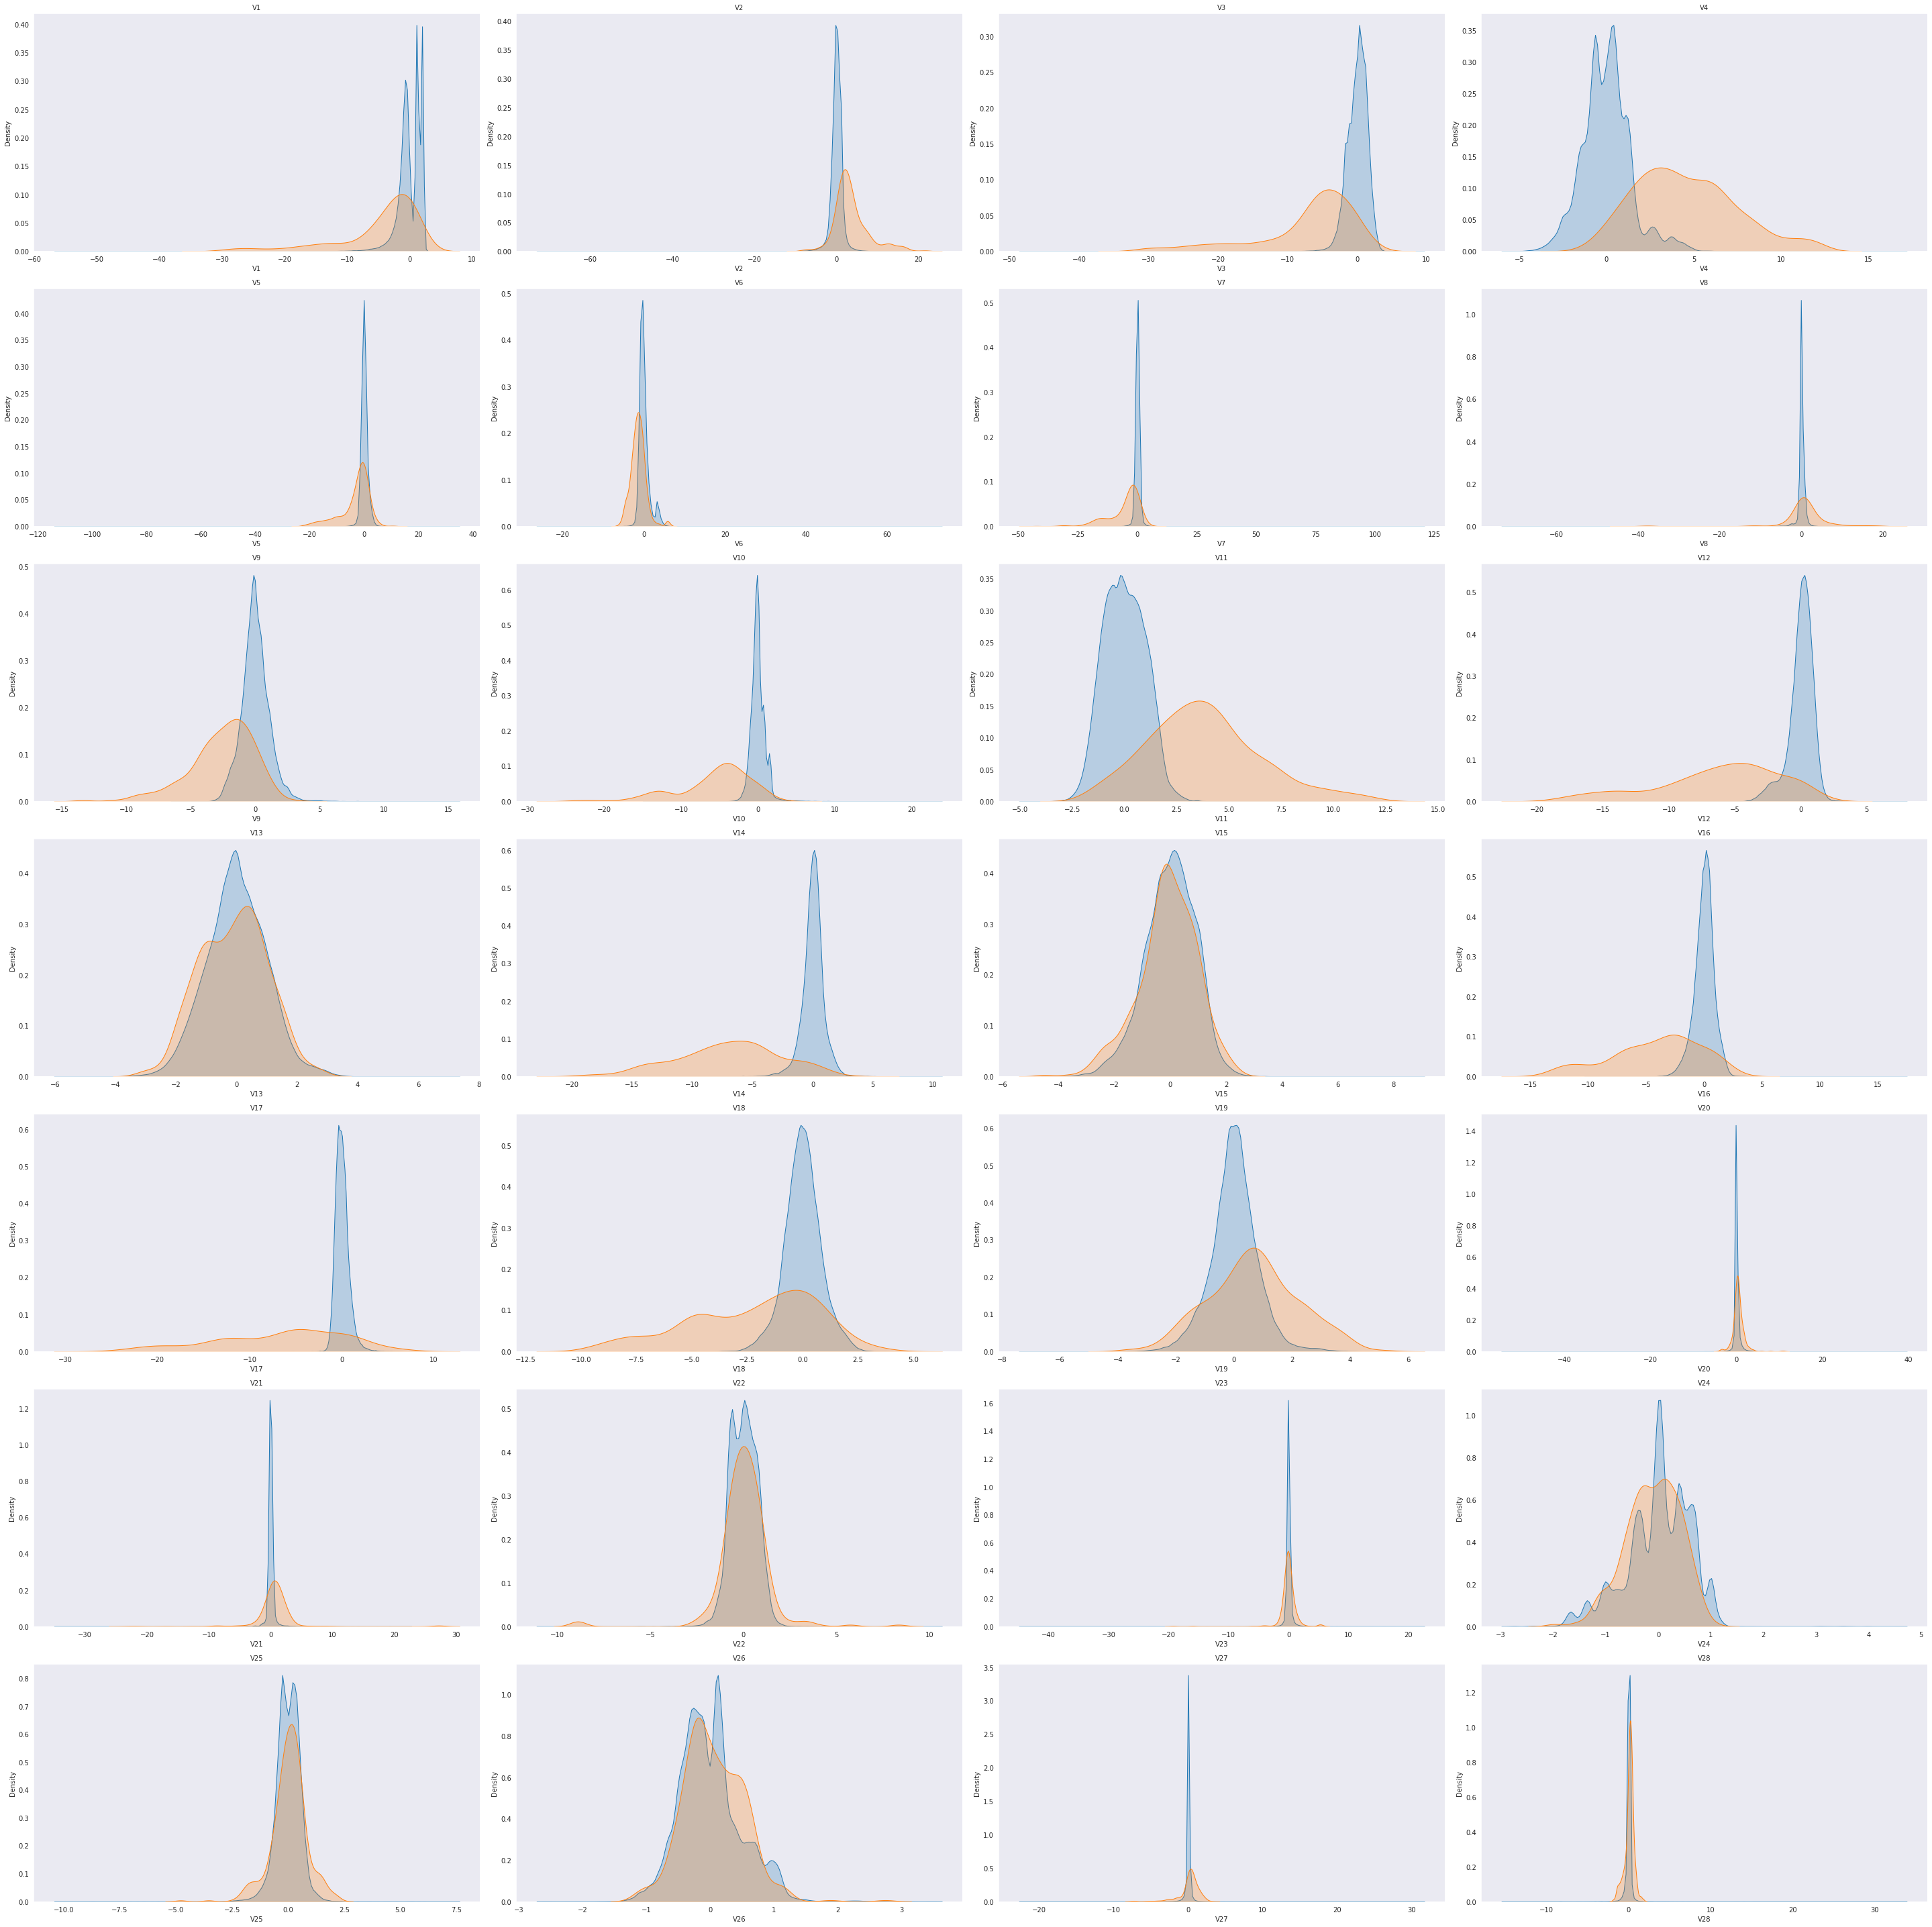

In [ ]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(40,40))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()


Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa de que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas.

## **3. Preparação dos Dados**

Para que os dados possam alimentar o modelo de Regressão Logística de forma corretas, iremos:
* Padronizar as features Time e Amount, que estão em outra ordem de grandeza;
* Separar os conjuntos de treino e teste;
* Balancear os dados a fim de evitar o overfitting e uma baixa performance para a classe 1.

### 3.1 Padronizar Time e Amount

Neste momento, iremos padronizar as colunas Amount e Time utilizando a classe StandardScaler

Visto que estas features estão em outras ordens de grandeza, é interessante fazer a normalização do dados. Para maiores informações, este [artigo](https://medium.com/tentando-ser-um-unic%C3%B3rnio/porqu%C3%AA-e-quando-%C3%A9-necess%C3%A1rio-normalizar-os-dados-92e5cce445aa)  explica em detalhes alguns dos motivos para este processo.

In [ ]:
# Padronizar as colunas Time e Amount
df_limpo = df.copy()

std_scaler = StandardScaler()
df_limpo['std_amount'] = std_scaler.fit_transform(df_limpo['Amount'].values.reshape(-1, 1))
df_limpo['std_time'] = std_scaler.fit_transform(df_limpo['Time'].values.reshape(-1, 1))

df_limpo.drop(['Time', 'Amount'], axis=1, inplace=True)

# Ver as primeiras entradas
df_limpo.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


### 3.2 Separar os conjuntos de treino e de teste

Antes de proceder com o balanceamento de dados, devemos separar os dados já existentes entre treino e teste. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado.

Para garantir que os conjuntos de treino e teste tenham a mesma quantidade de classes proporcionalmente, passamos 'stratify=True'.

In [ ]:
# Vamos separar as variáveis em X e y
X = df_limpo.drop('Class', axis = 1)
y = df['Class']

# Separar o dataset entre teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle=True)

Podemos também ver os formatos destas variáveis:

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((213605, 30), (213605,), (71202, 30), (71202,))

### 3.2 Balanceamento dos Dados

Utilizando a biblioteca imblearn, podemos aplicar técnicas de balanceamento de classes. Para este caso, iremos usar o Under-Sampling, que preserva a classe minoritária.

1    369
0    369
dtype: int64


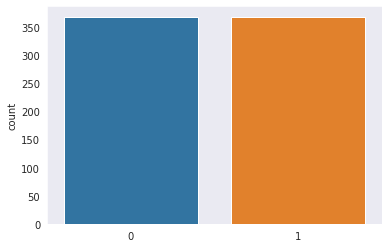

In [ ]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

Após balancearmos as classes, podemos utilizar um mapa de calor como uma matriz de correlações para vermos quais classes estão fortemente relacionadas.

Podemos notar também que, antes de balancearmos as classes, a matriz de correlação não apresentava informações relevantes. Logo, podemos ver como é importante o balanceamento.

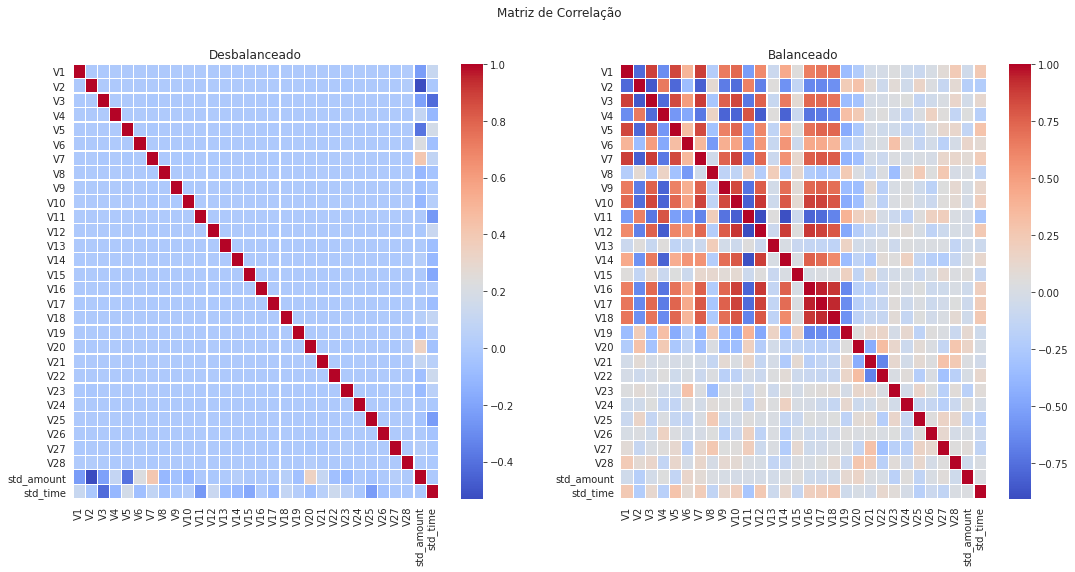

In [ ]:
# Plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado');

## **4. Criação do modelo de machine learning**

Para este projeto, iremos utilizar o modelo de Regressão Logística, o qual podemos construir após termos feito uma análise e preparado os dados.

Primeiro vamos instanciar o modelo utilizando os dados de X_rus e y_rus, e depois vamos realizar as previsões com os conjuntos de teste.

In [ ]:
# Criação e treinamento do modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# Previsões
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Após o treinamento do modelo, vamos para a avaliação do mesmo.

Neste tipo de problema, originalmente desbalanceado, a acurácia não é uma métrica adequada. Como pode ser lido [neste artigo](http://sigmoidal.ai/como-lidar-com-dados-desbalanceados/), podemos ter uma acurácia de 99,88% e detectar menos de 60% das fraudes.

Podemos também utilizar a matriz de confusão para vermos a taxa de acertos para transações fraudulentes, ou pela coluna *recall* do Relatório de Classificação. 

Uma outra métrica considerada interessante para se avaliar a eficácia é a [AUC ROC](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772), ou área sob a curva. No caso desse modelo de Regressão Logística, tem-se aproximadamente 94% de AUC, onde um resultado de 100% representaria previsões sem nenhum erro.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9579    0.9785     71079
           1     0.0364    0.9187    0.0701       123

    accuracy                         0.9579     71202
   macro avg     0.5181    0.9383    0.5243     71202
weighted avg     0.9982    0.9579    0.9769     71202

Acurácia: 0.9579

AUC: 0.9383



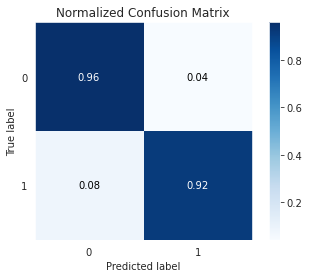

In [ ]:
# Matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# Acurácia do modelo
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}\n")

# Área sob a curva
print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}\n")

## **5. Conclusões**

Como podemos concluir, não se trata de um problema simples de ser resolvido, mesmo com o tratamento dos dados e da não existência de valores nulos e a Transformação PCA prévia, o desbalanceamento demanda um trabalho considerável.

Além disso, mesmo com um resultado interessante, este é apenas um modelo baseline, utilizando apenas um modelo de classificação, tendo espaço para comparação com outros modelos, além de também ser possível realizar o tuning dos hiperparâmetros, afim de buscar resultados ainda melhores.